### Select the Right Threshold values using ROC Curve

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# roc curve and auc score
from sklearn.datasets import make_classification
from sklearn.model_selection import RandomizedSearchCV 







CON='CL_buy'
train1=pd.read_csv('CL_buy_test.csv')
print(train1.shape)
train1 = train1.sample(frac = 1)
print(train1.tail(20))
train=train1.iloc[:int(0.9*len(train1)),]
test2= train1.iloc[int(0.9*len(train1)):,]
test=pd.read_csv('CL_buy_train.csv')
print(test.shape)
X_train=train.drop(["Profit"],axis=1)
y_train=train.Profit

X_test=test.drop(["Profit"],axis=1)
y_test=test.Profit

X_test2=test2.drop(["Profit"],axis=1)
y_test2=test2.Profit

In [61]:
import pandas as pd
CON='Opt_ES_buy_original'
data = pd.read_csv('Opt_ES.csv')
data=data.drop(['I31', 'Entry Time','Entry Price', 'Exit Price'],axis=1)
data.head(3)

data=data[data['Entry Name']=='R1 Buy']
data=data.drop(['Entry Name'],axis=1)
data=data.apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna()
data.head()
data=data.round(6)
data=data.dropna()
x1 = data.drop(["Profit"],axis=1)
y1 = data.Profit
data1 = pd.concat([x1,y1],axis=1)
data=data1.iloc[:int(0.9*len(data1)),]
data2=data1.iloc[int(0.9*len(data1)):,]
data2.shape

(167, 49)

In [62]:
train=data.iloc[:int(0.9*len(data)),]
test= data.iloc[int(0.9*len(data)):,]
vali=data2
print(vali.shape)
X_train=train.drop(["Profit"],axis=1)
y_train=train.Profit

X_test2=test.drop(["Profit"],axis=1)
y_test2=test.Profit

X_test=vali.drop(["Profit"],axis=1)
y_test=vali.Profit


# validate== xtest , ytest
## test== x_test2, y_test2

(167, 49)


In [63]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

#### Random Forests

In [64]:
from sklearn.ensemble import RandomForestClassifier

grid = { 'bootstrap': [True, False],
        'n_estimators':np.arange(400,1000,100),
        'criterion':['gini','entropy'],
        'max_depth': [5, 15, 20, 25,30],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10]
        
       }

rf = RandomForestClassifier(random_state = 42)
rf_model = RandomizedSearchCV(rf,grid,cv=5)
rf_model.fit(X_train,y_train)

print("Hyperparameters:",rf_model.best_params_)
print("Train Score:",rf_model.best_score_)
print("Test Score:",rf_model.score(X_test,y_test))

Hyperparameters: {'n_estimators': 700, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 5, 'criterion': 'entropy', 'bootstrap': False}
Train Score: 0.6646607259096317
Test Score: 0.6646706586826348


#### No we will focus on selecting the best threshold for maximum accuracy

In [65]:
pred=[]
for model in [rf_model]:
    pred.append(pd.Series(model.predict_proba(X_test2)[:,1]))
final_prediction=pd.concat(pred,axis=1).mean(axis=1)
print('Ensemble test roc-auc: {}'.format(roc_auc_score(y_test2,final_prediction)))

Ensemble test roc-auc: 0.5652312599681021


In [66]:
pd.concat(pred,axis=1)

,0
0,0.281744
1,0.342343
2,0.298672
3,0.299422
4,0.299073
...,...
162,0.332243
163,0.381627
164,0.304115
165,0.414937


In [67]:
final_prediction

0      0.281744
1      0.342343
2      0.298672
3      0.299422
4      0.299073
         ...   
162    0.332243
163    0.381627
164    0.304115
165    0.414937
166    0.361053
Length: 167, dtype: float64

In [68]:
#### Calculate the ROc Curve


fpr, tpr, thresholds = roc_curve(y_test2, final_prediction)
thresholds

array([1.51926727, 0.51926727, 0.46556722, 0.46248566, 0.41687988,
       0.41173804, 0.41167637, 0.4110802 , 0.40984936, 0.39521464,
       0.38162662, 0.38100361, 0.3776485 , 0.37376606, 0.37077259,
       0.36088792, 0.36063347, 0.35303561, 0.34822351, 0.34421031,
       0.34397049, 0.34360662, 0.34064482, 0.33567131, 0.33517722,
       0.33224275, 0.32782501, 0.32562898, 0.32346604, 0.31960883,
       0.31341378, 0.31147816, 0.31067853, 0.30784836, 0.30729908,
       0.30624338, 0.30566794, 0.30333797, 0.30324286, 0.29952146,
       0.29942174, 0.29332774, 0.29266933, 0.29149835, 0.29092224,
       0.29025767, 0.29015254, 0.28966577, 0.28876532, 0.28865881,
       0.28811367, 0.28407622, 0.2837253 , 0.28174392, 0.2790989 ,
       0.27738904, 0.2709322 , 0.26786705, 0.26324902, 0.26194599,
       0.25743088, 0.24710809])

In [69]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
accuracy_ls = []
recall_ls=[]
precision_ls=[]
precision_ls=[]
for thres in thresholds:
    y_pred = np.where(final_prediction>thres,1,0)
    accuracy_ls.append(accuracy_score(y_test2, y_pred, normalize=True))
    recall_ls.append(recall_score(y_test2, y_pred))
    precision_ls.append(precision_score(y_test2, y_pred))
    
accuracy_ls = pd.concat([pd.Series(thresholds), pd.Series(accuracy_ls),pd.Series(recall_ls),pd.Series(precision_ls)],
                        axis=1)
accuracy_ls.columns = ['thresholds', 'accuracy','recall','precision']
accuracy_ls.sort_values(by='precision', ascending=False, inplace=True)
accuracy_ls.head()

C:\Users\mk16m\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mk16m\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,thresholds,accuracy,recall,precision
2,0.465567,0.670659,0.035088,1.000000
3,0.462486,0.676647,0.052632,1.000000
4,0.416880,0.682635,0.087719,0.833333
5,0.411738,0.676647,0.105263,0.666667
7,0.411080,0.676647,0.122807,0.636364


In [70]:
accuracy_ls

,thresholds,accuracy,recall,precision
2,0.465567,0.670659,0.035088,1.000000
3,0.462486,0.676647,0.052632,1.000000
4,0.416880,0.682635,0.087719,0.833333
5,0.411738,0.676647,0.105263,0.666667
7,0.411080,0.676647,0.122807,0.636364
...,...,...,...,...
48,0.288765,0.353293,0.807018,0.321678
46,0.290153,0.359281,0.789474,0.321429
44,0.290922,0.365269,0.771930,0.321168
1,0.519267,0.658683,0.000000,0.000000


In [71]:
csv_save=CON+'.csv'
accuracy_ls.to_csv(csv_save)

In [72]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

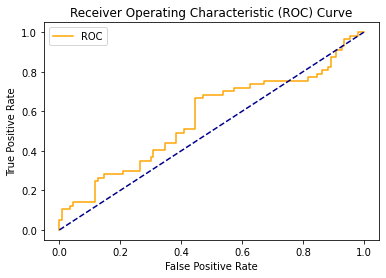

In [73]:
plot_roc_curve(fpr,tpr)

In [74]:
pred=[]
for model in [rf_model]:
    pred.append(pd.Series(model.predict_proba(X_test)[:,1]))
final_prediction=pd.concat(pred,axis=1).mean(axis=1)
print('Ensemble test roc-auc: {}'.format(roc_auc_score(y_test,final_prediction)))

Ensemble test roc-auc: 0.5652312599681021


this is precision ----> 1.0
FDAX BUY
Thresold values:  0.46556722054439287


C:\Users\mk16m\AppData\Local\Temp/ipykernel_6672/756368104.py:29: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(ttsave,dpi=300, facecolor='w', edgecolor='w', papertype=None, format=None, transparent=False)


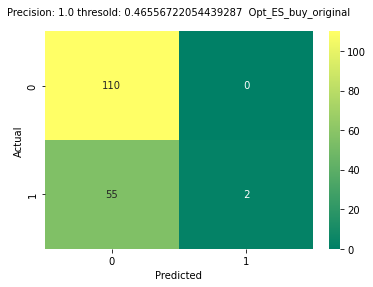

this is precision ----> 1.0
FDAX BUY
Thresold values:  0.4624856569963782


C:\Users\mk16m\AppData\Local\Temp/ipykernel_6672/756368104.py:29: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(ttsave,dpi=300, facecolor='w', edgecolor='w', papertype=None, format=None, transparent=False)


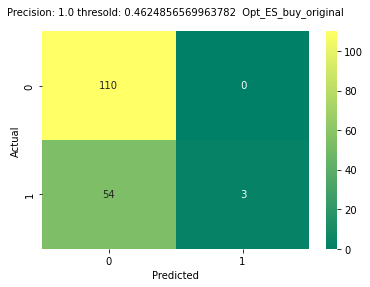

this is precision ----> 0.8333333333333334
FDAX BUY
Thresold values:  0.4168798755025439


C:\Users\mk16m\AppData\Local\Temp/ipykernel_6672/756368104.py:29: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(ttsave,dpi=300, facecolor='w', edgecolor='w', papertype=None, format=None, transparent=False)


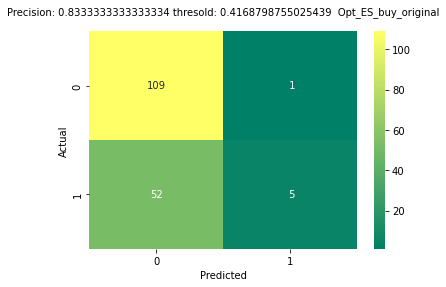

this is precision ----> 0.6666666666666666
FDAX BUY
Thresold values:  0.4117380393231988


C:\Users\mk16m\AppData\Local\Temp/ipykernel_6672/756368104.py:29: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(ttsave,dpi=300, facecolor='w', edgecolor='w', papertype=None, format=None, transparent=False)


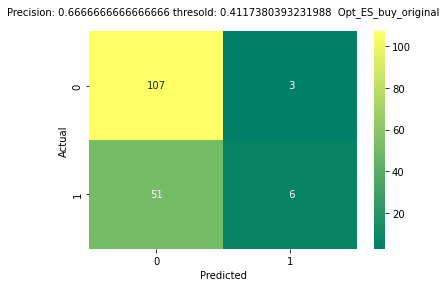

this is precision ----> 0.6363636363636364
FDAX BUY
Thresold values:  0.41108020103181764


C:\Users\mk16m\AppData\Local\Temp/ipykernel_6672/756368104.py:29: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(ttsave,dpi=300, facecolor='w', edgecolor='w', papertype=None, format=None, transparent=False)


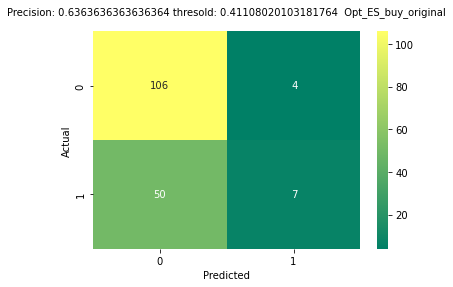

this is precision ----> 0.6
FDAX BUY
Thresold values:  0.41167637369963056


C:\Users\mk16m\AppData\Local\Temp/ipykernel_6672/756368104.py:29: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(ttsave,dpi=300, facecolor='w', edgecolor='w', papertype=None, format=None, transparent=False)


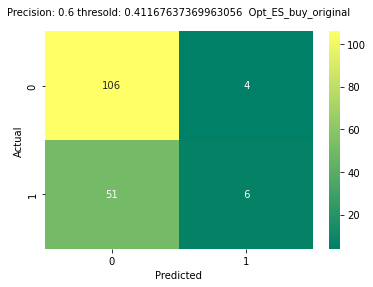

this is precision ----> 0.5833333333333334
FDAX BUY
Thresold values:  0.40984935500817876


C:\Users\mk16m\AppData\Local\Temp/ipykernel_6672/756368104.py:29: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(ttsave,dpi=300, facecolor='w', edgecolor='w', papertype=None, format=None, transparent=False)


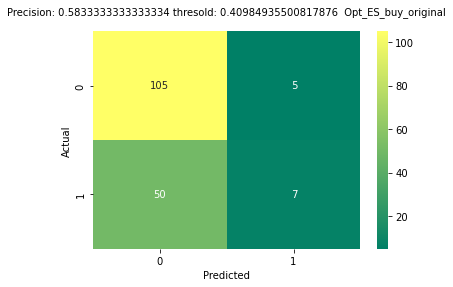

this is precision ----> 0.5185185185185185
FDAX BUY
Thresold values:  0.3810036053110461


C:\Users\mk16m\AppData\Local\Temp/ipykernel_6672/756368104.py:29: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(ttsave,dpi=300, facecolor='w', edgecolor='w', papertype=None, format=None, transparent=False)


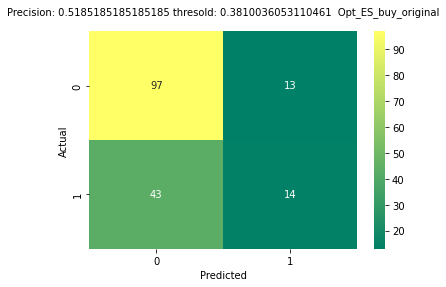

this is precision ----> 0.5
FDAX BUY
Thresold values:  0.37764849905725595


C:\Users\mk16m\AppData\Local\Temp/ipykernel_6672/756368104.py:29: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(ttsave,dpi=300, facecolor='w', edgecolor='w', papertype=None, format=None, transparent=False)


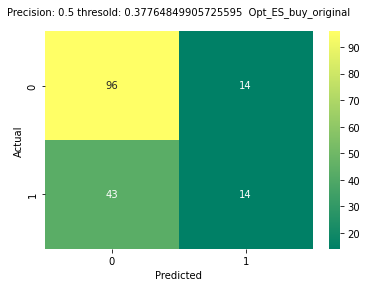

this is precision ----> 0.5
FDAX BUY
Thresold values:  0.3737660557890096


C:\Users\mk16m\AppData\Local\Temp/ipykernel_6672/756368104.py:29: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(ttsave,dpi=300, facecolor='w', edgecolor='w', papertype=None, format=None, transparent=False)


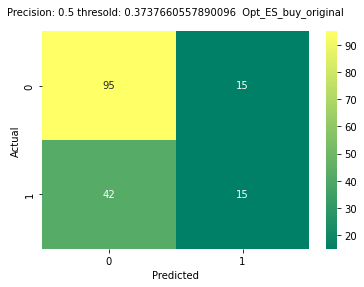

this is precision ----> 0.5
FDAX BUY
Thresold values:  0.38162661951709853


C:\Users\mk16m\AppData\Local\Temp/ipykernel_6672/756368104.py:29: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(ttsave,dpi=300, facecolor='w', edgecolor='w', papertype=None, format=None, transparent=False)


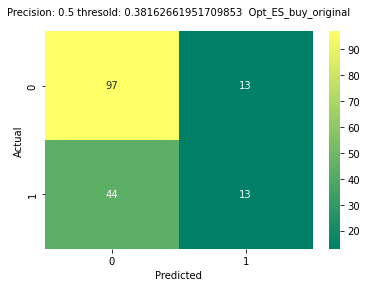

this is precision ----> 0.4838709677419355
FDAX BUY
Thresold values:  0.3707725868373527


C:\Users\mk16m\AppData\Local\Temp/ipykernel_6672/756368104.py:29: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(ttsave,dpi=300, facecolor='w', edgecolor='w', papertype=None, format=None, transparent=False)


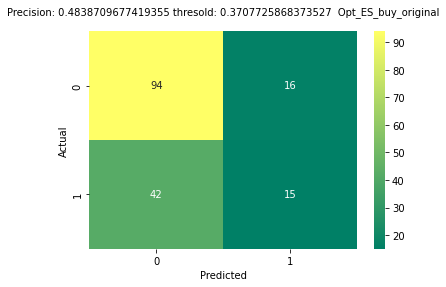

this is precision ----> 0.43023255813953487
FDAX BUY
Thresold values:  0.31341378241404527


C:\Users\mk16m\AppData\Local\Temp/ipykernel_6672/756368104.py:29: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(ttsave,dpi=300, facecolor='w', edgecolor='w', papertype=None, format=None, transparent=False)


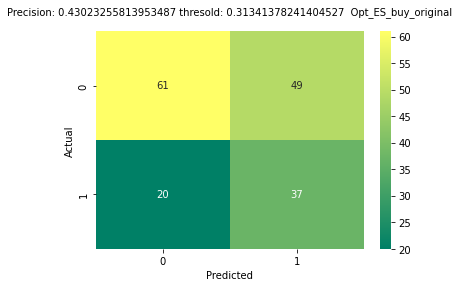

this is precision ----> 0.42696629213483145
FDAX BUY
Thresold values:  0.3114781641986579


C:\Users\mk16m\AppData\Local\Temp/ipykernel_6672/756368104.py:29: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(ttsave,dpi=300, facecolor='w', edgecolor='w', papertype=None, format=None, transparent=False)


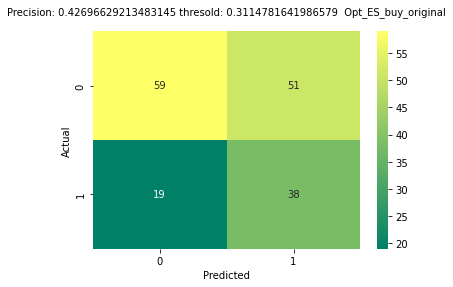

this is precision ----> 0.4222222222222222
FDAX BUY
Thresold values:  0.3106785331993597


C:\Users\mk16m\AppData\Local\Temp/ipykernel_6672/756368104.py:29: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(ttsave,dpi=300, facecolor='w', edgecolor='w', papertype=None, format=None, transparent=False)


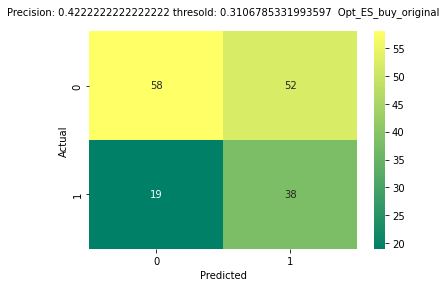

In [75]:

for i in range(15):
    TS= accuracy_ls.iloc[i,0]
    pred = np.where(final_prediction>TS,1,0)

    import seaborn as sns
    from sklearn.metrics import classification_report
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import plot_confusion_matrix
    import matplotlib.pyplot as plt
    #pred=rf_cv.predict(x_test)
    cm=confusion_matrix(y_test,pred)
    fn = cm[0][1]
    #print(fn)
    tp = cm[1][1]
    try:
        recall= float(tp)/(float(tp)+float(fn))
    except: 
        recall= 'NONE'
    print("this is precision ---->", recall)
    print('FDAX BUY')
    print('Thresold values: ', TS)
    ttt="Precision: "+str(recall)+ ' thresold: '+str(TS)+"  "+ str(CON)
    ttsave=str(i)+str(CON)+"Precision"+str(recall)+'thresold'+str(TS)+'.png'
    sns.heatmap(confusion_matrix(y_test,pred),annot=True,fmt='2.0f',cmap="summer")
    plt.title(ttt, y=1.05, size=10)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    
    plt.savefig(ttsave,dpi=300, facecolor='w', edgecolor='w', papertype=None, format=None, transparent=False)
    plt.show()
  